## Goal: What does expression distribution look like for LAPA TSSs?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df = df.loc[df.mixed_samples==False]
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID', 'lab_sample']].drop_duplicates()

In [4]:
# make parent table
files  = expand(proc_cfg(config['lr']['lapa']['pls_int'], od),
                   sample=df['sample'].tolist())
big_df = pd.DataFrame()
for f, s in zip(files, df['sample'].tolist()):
    assert s in f
    temp = pd.read_csv(f, sep='\t')
    temp['sample'] = s
    big_df = pd.concat([big_df, temp], axis=0)

In [5]:
# merge w/ population information
meta_df = load_meta()
meta_df['eur'] = 'Non-European'
meta_df.loc[meta_df['population'].isin(['AJI', 'CEU']), 'eur'] = 'European'
big_df = big_df.merge(meta_df[['sample', 'population',
                               'map_reads_assemblymap', 
                               'ooa', 'eur']], 
                      how='left',
                      on='sample')

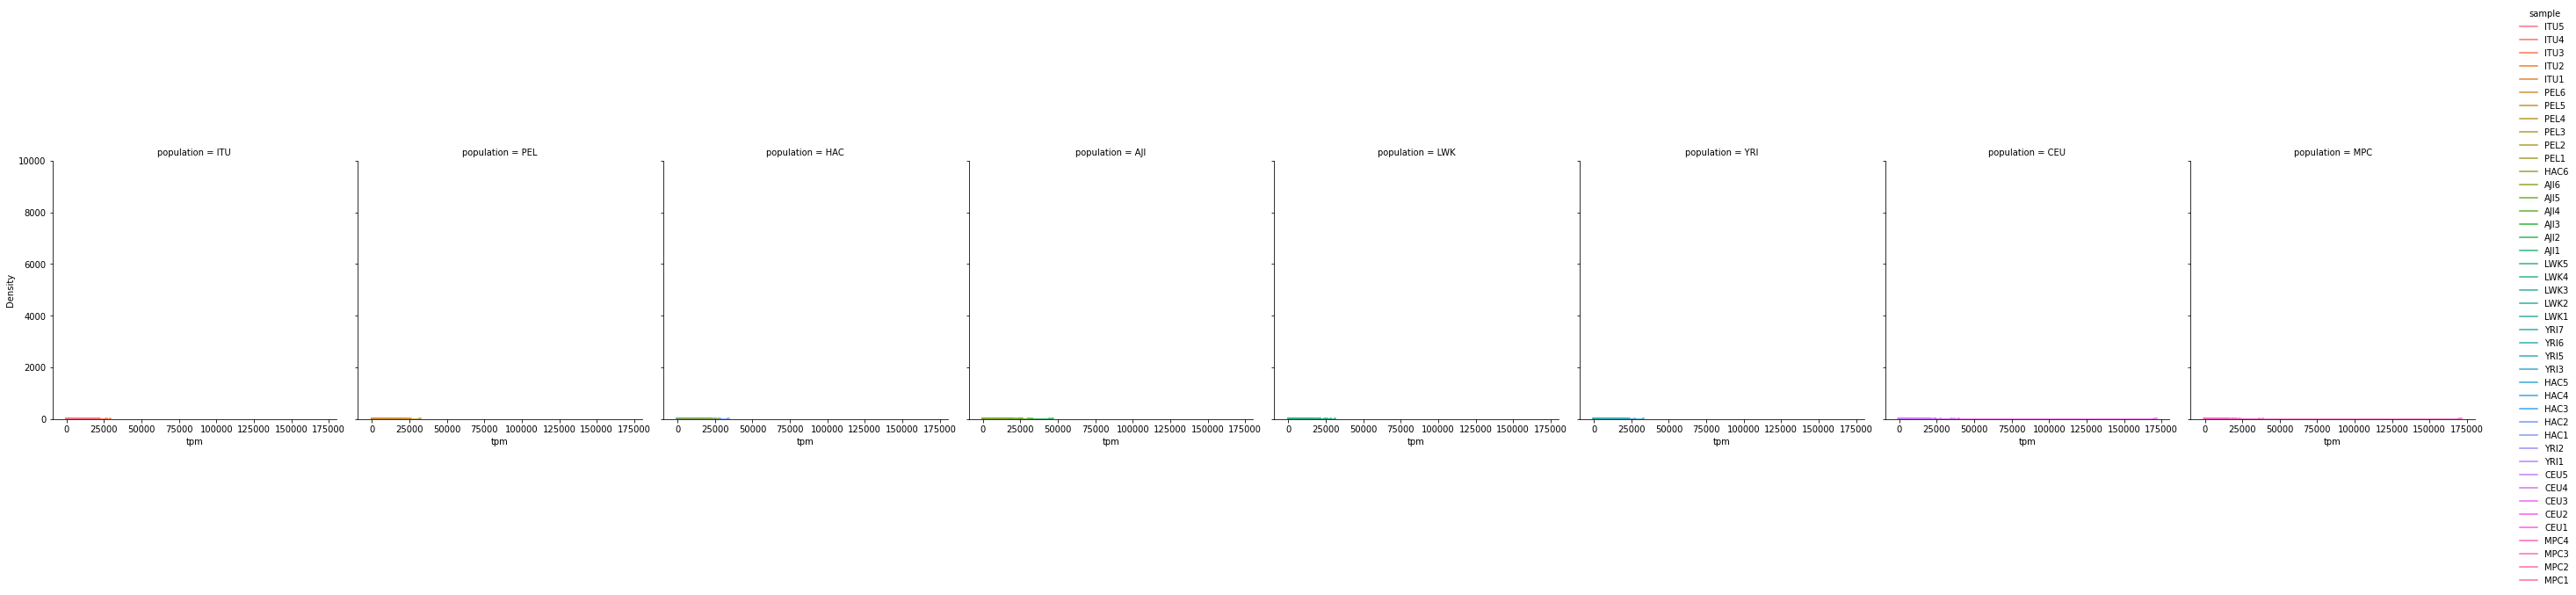

In [9]:
c_dict, order = get_population_colors()
ax = sns.displot(big_df,
            x='tpm',
            col='population',
            kind='kde',
            hue='sample'
            )
ax.set(ylim=(0, 10e3))
# sns.displot(data=penguins, x="flipper_length_mm",
#             hue="species", col="sex", kind="kde")
